# Transfer Learning Part 1: Feature Extraction

Transfer learning is a leveraging a working model's existing architecture and learned paterns for our own problem.

There are two main benefits:
* Can leverage an existing neural network architecture proven to work on problems similar to our own
* Can leverage a working neural network architecture which has already learned patterns on similar data to or own, then we can adapt those patterns to our own data.

In [1]:
# Import Libraries
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Downloading and becoming one with data

In the last notebook, we used Food101 data and work with all the data however this time we will use only 10 percent of the same data and try to see power of transfer learning.

In [2]:
# Get data (%10 of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-04 10:34:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.8MB/s    in 6.4s    

2023-07-04 10:34:23 (25.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through 10 percent data directory and list number of files
for dir in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizz

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
# Set the global variables
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# Setup data inputs
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SIZE,
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE)

print('\nTest images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SIZE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE)

Training images:
Found 750 images belonging to 10 classes.

Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be perfomeed during or after training. Some of the most populer callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create a TensorBoard callbakc (functionized because we need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past notebooks, we created our model's architecture layer by layer from scratch. Now, we are going to do similar proces but majority of our model's layers will come from TensorFlow Hub. Here you can find out pretrained models: https://tfhub.dev/

After browsing in TensorFlow Hub, I found out following feature vector models:

* efficientnet: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
* resnet: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
+ mobilenet: https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5

In [26]:
# Let's compare the following models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
mobilenet_url='https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'

In [7]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
    '''
    Takes a TensorFlow Hub url and create a model sequential

    Args:
        model_url(str): A Tensorflow Hub url
        num_classes(int): A number of output neurons in the output layer. Should be equal to target classes. Default 10

    Returns:
        An uncomplied Keras Sequential model with model_url
    '''


    # Download the pretrained model and save it as a Keras layer
    feature_extract_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SIZE+(3,)) # freeze the already learned patterns

    # Create the model
    model = tf.keras.Sequential([
        feature_extract_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

### Creating and testing Resnet TensorFlow Hub feature extraction model


In [8]:
# Create Resnet model
resnet_model = create_model(model_url=resnet_url, num_classes=train_data.num_classes)

In [9]:
# Summary of the resnet_model
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


There are `23,585,290` params but only `20,490` of them trainable. Actually, that summarize the transfer learnin well.

In [10]:
# Compile the model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [11]:
# Fit the resnet_model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet_v2_50')])

Saving TensorBoard log files to: tensorflow_hub/resnet_v2_50/20230704-103437
Epoch 1/5
24/24 [==============================] - 35s 846ms/step - loss: 1.9586 - accuracy: 0.3507 - val_loss: 1.1800 - val_accuracy: 0.6496
Epoch 2/5
24/24 [==============================] - 18s 781ms/step - loss: 0.9025 - accuracy: 0.7373 - val_loss: 0.8189 - val_accuracy: 0.7588
Epoch 3/5
24/24 [==============================] - 17s 741ms/step - loss: 0.6381 - accuracy: 0.8133 - val_loss: 0.7376 - val_accuracy: 0.7676
Epoch 4/5
24/24 [==============================] - 18s 765ms/step - loss: 0.4845 - accuracy: 0.8707 - val_loss: 0.6911 - val_accuracy: 0.7848
Epoch 5/5
24/24 [==============================] - 17s 747ms/step - loss: 0.3896 - accuracy: 0.9027 - val_loss: 0.6627 - val_accuracy: 0.7888


This transfer learning feature extractor model performed well. Compared with previous models, we get higher score and quicker training time by the way note that we only use 10 percent of the data.

Now, lets create a plot that show us loss and accuracy curves.

In [12]:
# Create a function to plot loss and accuracy
def plot_loss_curves(history):

    '''
    Plot the loss and accuracy curves for training and validation parts.

    Args:
        history: TensorFlow history object.
    Returns:
        Loss and accuracy curves for training and validation
    '''

    # Convert history to dataframe
    dataframe = pd.DataFrame(resnet_history.history)
    dataframe = dataframe.set_index(pd.Index(range(1, len(dataframe) + 1)))

    # Set the plot size
    plt.figure(figsize=(12, 5))

    # Plot train and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(dataframe['loss'], 'b', label='Train loss')
    plt.plot(dataframe['val_loss'], 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(dataframe['accuracy'], 'b', label='Train accuracy')
    plt.plot(dataframe['val_accuracy'], 'r', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    # Adjust spaces and plot
    plt.subplots_adjust(wspace=0.3)
    plt.show()

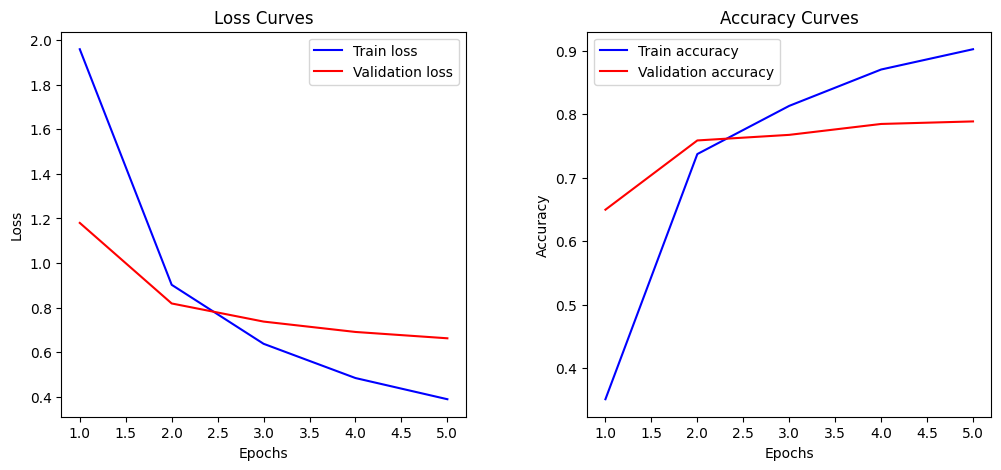

In [13]:
# Plot the resnet model's history
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub feature extraction model

In [14]:
# Create EfficientNet feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data.num_classes)

In [15]:
# Model summary
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [16]:
# Compile the efficientnet model
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [17]:
# Fit the efficientnet model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='efficientnet_B0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnet_B0/20230704-103638
Epoch 1/5
24/24 [==============================] - 31s 869ms/step - loss: 1.8547 - accuracy: 0.4453 - val_loss: 1.2836 - val_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 18s 756ms/step - loss: 1.0461 - accuracy: 0.7840 - val_loss: 0.8575 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 17s 711ms/step - loss: 0.7511 - accuracy: 0.8360 - val_loss: 0.6895 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 17s 732ms/step - loss: 0.6044 - accuracy: 0.8693 - val_loss: 0.6105 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 17s 743ms/step - loss: 0.5086 - accuracy: 0.8893 - val_loss: 0.5532 - val_accuracy: 0.8616


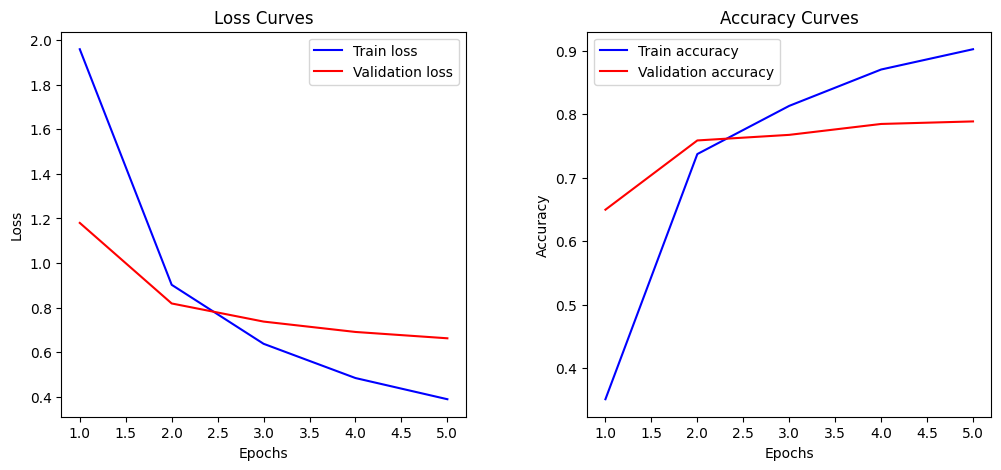

In [18]:
# Let's plot the loss curves
plot_loss_curves(efficientnet_history)

In [19]:
# How many layer does our efficient net model have?
len(efficientnet_model.weights)

311

### Creating and testing MobileNetV2 TensorFlow Hub feature extraction model

In [27]:
# Create the MobileNetV2 feature extractor model
mobilenet_model = create_model(model_url=mobilenet_url,
                               num_classes=train_data.num_classes)

In [28]:
# Summary of the MobileNetV2
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
# Compile the model
mobilenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [32]:
# Fit the model
mobilenet_history = mobilenet_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='mobilenet_v2')])

Saving TensorBoard log files to: tensorflow_hub/mobilenet_v2/20230704-112445
Epoch 1/5
24/24 [==============================] - 22s 761ms/step - loss: 1.9966 - accuracy: 0.3347 - val_loss: 1.3272 - val_accuracy: 0.6132
Epoch 2/5
24/24 [==============================] - 16s 687ms/step - loss: 1.0631 - accuracy: 0.7320 - val_loss: 0.9126 - val_accuracy: 0.7320
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.7688 - accuracy: 0.8040 - val_loss: 0.7624 - val_accuracy: 0.7780
Epoch 4/5
24/24 [==============================] - 16s 708ms/step - loss: 0.5936 - accuracy: 0.8560 - val_loss: 0.6868 - val_accuracy: 0.7992
Epoch 5/5
24/24 [==============================] - 16s 681ms/step - loss: 0.4954 - accuracy: 0.8760 - val_loss: 0.6586 - val_accuracy: 0.7948


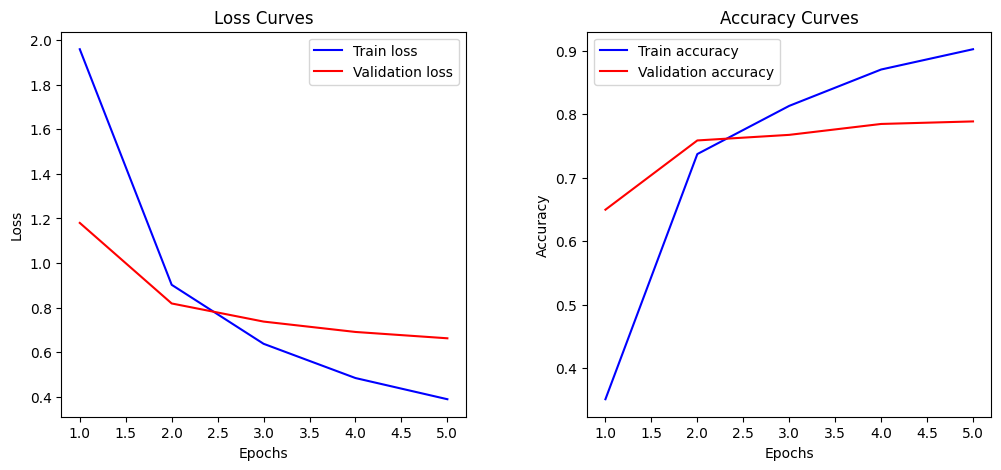

In [33]:
# Plot the loss curves
plot_loss_curves(mobilenet_history)

## Different types of transfer learning

* **'As is' transfer learning** - Using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes)
* **'Feature extraction' transfer learning** - Use the pretrained patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **'Fine-tuning' transfer learning** - use the pretrained patterns of an existing model and 'fine-tune' many or all of the underlying layers (including new output layers)

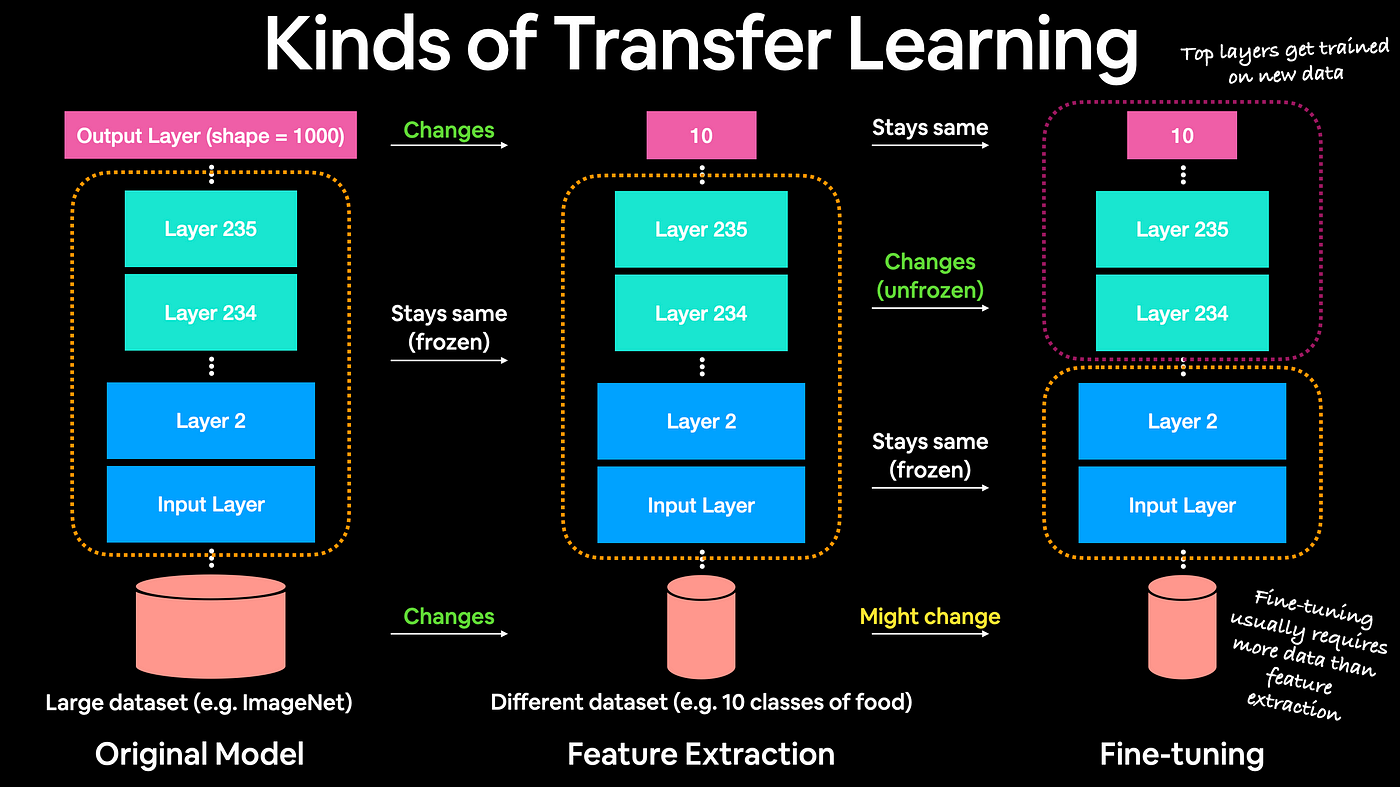

## Comparing models results using TensorBoard

In [34]:
# Upload TensorBoard dev records
! tensorboard dev upload --logdir ./tensorflow_hub/ \
--name 'EfficientNetB0 vs ResNet50V2' \
--description 'Comparing two different TF Hub feature extraction model using %10 of the training data' \
--one_shot

2023-07-04 11:29:00.760445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/6BKiNN64QaWSQZqJIrmhGA/

[2023-07-04T11:29:02] Started scanning logdir.
[2023-07-04T11:29:09] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.1 MB)
[2023-07-04T11:29:09] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/6BKiNN64QaWSQZqJIrmhGA/


Our TensorBoard published at here: https://tensorboard.dev/experiment/6BKiNN64QaWSQZqJIrmhGA/

In [36]:
# Check out the what tensorboard experiment we have
! tensorboard dev list

2023-07-04 11:29:20.920973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/6BKiNN64QaWSQZqJIrmhGA/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model using %10 of the training data
	Id                   6BKiNN64QaWSQZqJIrmhGA
	Created              2023-07-04 11:29:02 (20 seconds ago)
	Updated              2023-07-04 11:29:09 (13 seconds ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7454899
https://tensorboard.dev/experiment/8gX4KDSyRZCbu6dY6diN7Q/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model using %10 of the training data
	Id                   8gX4KDSyRZCbu6dY6diN7Q
	Created              2023-07-04 10:45:34 (43 minutes ago)
	Updated              2023-07-04 10:45:38 (4

In [38]:
# Delete an experiment which id number is 8gX4KDSyRZCbu6dY6diN7Q
! tensorboard dev delete --experiment_id 8gX4KDSyRZCbu6dY6diN7Q

2023-07-04 11:31:23.488416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment 8gX4KDSyRZCbu6dY6diN7Q.


In [39]:
# Check out tensorboard experiment again
! tensorboard dev list

2023-07-04 11:31:27.888875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/6BKiNN64QaWSQZqJIrmhGA/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model using %10 of the training data
	Id                   6BKiNN64QaWSQZqJIrmhGA
	Created              2023-07-04 11:29:02 (2 minutes ago)
	Updated              2023-07-04 11:29:09 (2 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7454899
Total: 1 experiment(s)


We successfully deleted a tensorboard experiment which id number is 8gX4KDSyRZCbu6dY6diN7Q